\begin{aligned}
-\Delta u & = f && \text {En una resistencia eléctrica},
\\
&\alpha u − \beta = 0 && \text{Con condición en la frontera tipo Robin}\\
& z = \frac{\text{area}}{1 + \frac{\text{temp\_max}}{T_{\text{amb}}}} && \text{Función Objetivo}
\end{aligned}

- `import numpy as np`: Importa la librería NumPy con el alias np.
- `from ngsolve import *`: Importa todo desde el módulo ngsolve.
- `from ngsolve.webgui import Draw`: Importa la función Draw del módulo ngsolve.webgui.
- `from netgen.geom2d import CSG2d, Circle, Rectangle`: Importa las clases CSG2d, Circle y Rectangle del módulo netgen.geom2d.
- `import matplotlib.pyplot as plt`: Importa la librería matplotlib.pyplot con el alias plt.

In [1]:
import numpy as np
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
import matplotlib.pyplot as plt

- `def areamax_tempmax(espesor, radio_externo, longitud_segmentos_rectos,graficar):`: Define una función para calcular el área y la temperatura máxima de una geometría.

  - `geo = CSG2d()`: Crea una geometría en 2D usando CSG2d.

  - `circle1 = Circle(...)`, `circle2 = Circle(...)`, `rect1 = Rectangle(...)`, `rect2 = Rectangle(...)`: Define círculos y rectángulos para la geometría.

  - `domain3 = (circle1 + rect1) - (circle2 + rect2)`: Combina los círculos y rectángulos para formar la geometría final.

  - `mesh = geo.GenerateMesh(maxh=espesor/4)`: Genera una malla para la geometría.

  - `if graficar: Draw(mesh)`: Si `graficar` es verdadero, muestra la malla.

  - `fes = H1(mesh, order=1, dirichlet="bc_rect1|bc_circle1")`: Define un espacio de funciones H1 con condiciones de contorno Dirichlet.

  - `area = Integrate(cf, mesh, VOL, region_wise=True)`: Calcula el área de la geometría.

  - `if graficar: print("Área de la geometría:", area)`: Si `graficar` es verdadero, imprime el área.

  - `a = BilinearForm(fes)`, `f = LinearForm(fes)`: Define formas bilineales y lineales para resolver el problema de transferencia de calor.

  - `gfu.Set(CF(g), BND)`: Impone una condición de contorno de Dirichlet en la frontera.

  - `a += alpha * u * v * ds(robin_boundary)`, `f += -beta * v * ds(robin_boundary)`: Agrega términos de la condición de Robin a la forma bilineal y lineal.

  - `solvers.BVP(bf=a, lf=f, gf=gfu, pre=c)`: Resuelve el problema de transferencia de calor.

  - `if graficar: Draw(gfu)`: Si `graficar` es verdadero, muestra la solución.

  - `max_temp = np.max(gfu.vec.data)`: Calcula la temperatura máxima.

  - `print(f"Máximo valor de la temperatura: {max_temp}")`: Imprime el máximo valor de la temperatura.

  - `return area,max_temp`: Retorna el área y la temperatura máxima.


In [2]:
def areamax_tempmax(espesor, radio_externo, segmentos, graficar):
    # Crear geometría
    geo = CSG2d()
    circle1 = Circle(center=(segmentos + np.sqrt(radio_externo**2-4), 2), radius=radio_externo, mat="mat1", bc="bc_circle1")
    circle2 = Circle(center=(segmentos + np.sqrt(radio_externo**2-4), 2), radius=radio_externo - espesor, mat="mat2", bc="bc_circle2")
    rect1 = Rectangle(pmin=(0, 0), pmax=(segmentos, 4), mat="mat1", bc="bc_rect1")
    rect2 = Rectangle(pmin=(-0.5, espesor), pmax=(segmentos+2*espesor, 4-espesor), mat="mat2", bc="bc_rect2")
    domain3 = (circle1 + rect1) - (circle2 + rect2)
    geo.Add(domain3)
    # Generar malla
    mesh = geo.GenerateMesh(maxh=espesor/4)
    mesh = Mesh(mesh)
    mesh.Curve(1)
    if graficar: 
        Draw(mesh)
    
    # Calcular el área
    fes = H1(mesh, order=1, dirichlet="bc_rect1|bc_circle1")
    u = fes.TrialFunction()  
    v = fes.TestFunction()   
    gfu = GridFunction(fes)  
    g = 283.15 
    cf = mesh.RegionCF(VOL, dict(mat1=1))
    area = Integrate(cf, mesh, VOL, region_wise=True)
    if graficar:
        print("Área de la geometría:", area)
    temp_max=g

    u = fes.TrialFunction()
    v = fes.TestFunction()

    cond = 320*100 

    a = BilinearForm(fes)
    a += grad(u)*grad(v)*cond*dx

    P=1.0E7
    Q=P/area[0] 
    f = LinearForm(fes)
    f += Q*v*dx

    gfu.Set(CF(g), BND)

    a.Assemble()
    f.Assemble()

    H = 250  
    T_amb = 283.15  
    alpha = H
    beta = -H * T_amb
    robin_boundary = 'bc_rect1|bc_circle1|bc_circle2'
    a += alpha * u * v * ds(robin_boundary)
    f += -beta * v * ds(robin_boundary)
    c = Preconditioner(a,"direct") 
    c.Update()
    solvers.BVP(bf=a, lf=f, gf=gfu, pre=c);
    if graficar:
        Draw(gfu)
    max_temp = np.max(gfu.vec.data)
    print(f"Máximo valor de la temperatura: {max_temp}")
    return area,max_temp

- Se definen las variables `espesor`, `radio_externo` y `segmentos` con sus valores iniciales.
- Se definen los parámetros para el algoritmo genético: `population_size`, `num_iterations`, `mutation_rate`, `crossover_rate` y `elitism`.
- Se establecen los rangos de valores para `espesor`, `radio_externo` y `segmentos`.
- Se genera una población inicial aleatoria dentro de los rangos definidos.
- Se define la función objetivo que considera también el número de segmentos para calcular el área y la temperatura máxima.
- Se evalúa la población inicial y se encuentra la mejor solución y su rendimiento.
- Se muestra la mejor solución y su rendimiento.
- Se calcula el área y la temperatura máxima para la mejor solución.
- Se reinician las variables `best_solution` y `best_fitness`.
- Se define la función de selección de padres, cruce y mutación para tres variables.


In [3]:
espesor = 1.9
radio_externo = 8
segmentos=5
population_size = 20 
num_iterations = 10 
mutation_rate = 0.01 
crossover_rate = 0.4 
elitism = False

espesor_range = (0.2, 1.8)
radio_externo_range = (5.0, 12)
segmentos_range = (3, 8)
population = np.random.rand(population_size,3)
population[:,0]=population[:,0]*(espesor_range[1]-espesor_range[0])+espesor_range[0]
population[:,1]=population[:,1]*(radio_externo_range[1]-radio_externo_range[0])+radio_externo_range[0]
population[:,2]=population[:,2]*(segmentos_range[1]-segmentos_range[0])+segmentos_range[0]

def objective_function(x, graficar):
    area,temp_max = areamax_tempmax(espesor=x[0], radio_externo=x[1], segmentos=x[2], graficar=graficar)
    T_amb=283.15
    area = area.NumPy()
    return area/(1+temp_max/T_amb)

fitness = np.array([objective_function(x, graficar=True) for x in population])
best_idx = np.argmax(fitness)
best_solution = population[best_idx]
best_fitness = fitness[best_idx]

print(f"Mejor solución (espesor, radio_externo, segmentos): {best_solution}")
print(f"Mejor rendimiento: {best_fitness}")

area, temp_max = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], segmentos=best_solution[2], graficar=True)

print(f"Área: {area}, Temperatura Máxima: {temp_max}")

best_solution = None
best_fitness = float('-inf')
mean_fitnesses = []

def select_parents(population, fitness):
    idxs = np.random.choice(len(population), size=2, replace=False)
    return population[idxs[np.argmax(fitness[idxs])]]
    
def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        child1 = 0.5 * (parent1 + parent2) + np.random.normal(0, 0.1, size=3)
        child2 = 0.5 * (parent1 + parent2) + np.random.normal(0, 0.1, size=3)
        child1[0] = np.clip(child1[0], espesor_range[0], espesor_range[1])
        child1[1] = np.clip(child1[1], radio_externo_range[0], radio_externo_range[1])
        child1[2] = np.clip(child1[2], segmentos_range[0], segmentos_range[1])
        child2[0] = np.clip(child2[0], espesor_range[0], espesor_range[1])
        child2[1] = np.clip(child2[1], radio_externo_range[0], radio_externo_range[1])
        child2[2] = np.clip(child2[2], segmentos_range[0], segmentos_range[1])
        return child1, child2
    return parent1, parent2

def mutate(individual):
    if np.random.rand() < mutation_rate:
        individual += np.random.normal(0, 0.1, size=3)
        individual[0] = np.clip(individual[0], espesor_range[0], espesor_range[1])
        individual[1] = np.clip(individual[1], radio_externo_range[0], radio_externo_range[1])
        individual[2] = np.clip(individual[2], segmentos_range[0], segmentos_range[1])
    return individual

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  86.3931

CG iteration 1, residual = 590498.5671721859     
CG iteration 2, residual = 3.614855300777508e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 291.2197638459549


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  65.3125

CG iteration 1, residual = 552668.3187963043     
CG iteration 2, residual = 3.5843085142237753e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 292.2709718972211


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  125.997

CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.3628670752245


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  53.5522

CG iteration 1, residual = 689675.2452049665     
CG iteration 2, residual = 4.4906364821728224e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.79512867406424


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  39.3331

CG iteration 1, residual = 1164118.3309671008     
CG iteration 2, residual = 7.576298020664801e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 285.1347008125237


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  83.4557

CG iteration 1, residual = 641273.0470610153     
CG iteration 2, residual = 4.1283755022349173e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 289.8426245640536


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  45.9147

CG iteration 1, residual = 607606.1994280544     
CG iteration 2, residual = 3.669037325411531e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 290.3837053335623


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  68.3873

CG iteration 1, residual = 832162.5853521152     
CG iteration 2, residual = 6.316781154982178e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.11297912224336


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  44.6451

CG iteration 1, residual = 802725.5275392685     
CG iteration 2, residual = 5.051123182719099e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.2898047155447


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:   59.827

CG iteration 1, residual = 606677.3283223103     
CG iteration 2, residual = 3.9754246894931777e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 290.445677837432


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  70.3246

CG iteration 1, residual = 803961.7044696186     
CG iteration 2, residual = 5.146375617643376e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 287.33852509595056


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  48.3179

CG iteration 1, residual = 1002692.5708760193     
CG iteration 2, residual = 7.174743711749958e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 285.80197885566236


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  39.1687

CG iteration 1, residual = 1174030.4080393033     
CG iteration 2, residual = 7.180342253255927e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 285.0875850845684


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  40.6318

CG iteration 1, residual = 673877.9737214097     
CG iteration 2, residual = 4.720293949524136e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.77709965429267


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  30.9877

CG iteration 1, residual = 875114.3776939962     
CG iteration 2, residual = 5.560564803954698e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 286.4387341014183


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  40.5572

CG iteration 1, residual = 915197.2867738353     
CG iteration 2, residual = 6.070430709512285e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 286.25159616045124


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  45.4545

CG iteration 1, residual = 702301.6561919142     
CG iteration 2, residual = 4.4780540491774757e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.3973688089078


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  16.9389

CG iteration 1, residual = 1699401.7614806574     
CG iteration 2, residual = 1.244478655173274e-09     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 284.0609443322107


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  116.044

CG iteration 1, residual = 728097.0720168784     
CG iteration 2, residual = 5.164770821136253e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.50653811419903


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  69.2701

CG iteration 1, residual = 590590.0941791658     
CG iteration 2, residual = 3.7157641963548394e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 291.0294353031244
Mejor solución (espesor, radio_externo, segmentos): [ 1.60459526 11.48742294  6.19096936]
Mejor rendimiento: [62.42373422]


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  125.997

CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.3628670752245
Área:  125.997
, Temperatura Máxima: 288.3628670752245


- El algoritmo genético se ejecuta durante un número de iteraciones (`num_iterations`).
- En cada iteración, se seleccionan los padres y se realiza el cruce para generar una nueva población.
- Se implementa el elitismo, si está activado, para conservar una parte de la población anterior.
- Se evalúa la nueva población y se actualiza la mejor solución si se encuentra una aptitud mayor.
- Se muestra una visualización tridimensional de la población y la mejor solución en cada iteración.
- Se imprime el progreso del algoritmo en cada iteración, mostrando la mejor solución y su aptitud.
- Al finalizar las iteraciones, se muestra la mejor solución encontrada y su aptitud inal.


CG iteration 1, residual = 886769.6064812029     
CG iteration 2, residual = 5.676079471059972e-10     
Máximo valor de la temperatura: 286.57630399109075
CG iteration 1, residual = 869562.1318338168     
CG iteration 2, residual = 5.506817392256052e-10     
Máximo valor de la temperatura: 286.7207068821672
CG iteration 1, residual = 720804.7071423713     
CG iteration 2, residual = 4.5794626982717647e-10     
Máximo valor de la temperatura: 288.55188177441937
CG iteration 1, residual = 782322.3527342407     
CG iteration 2, residual = 5.105920806795006e-10     
Máximo valor de la temperatura: 287.72803859599793
CG iteration 1, residual = 607606.1994280544     
CG iteration 2, residual = 3.669037325411531e-10     
Máximo valor de la temperatura: 290.3837053335623
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 714785.1607533171     
CG iteration 2, residu

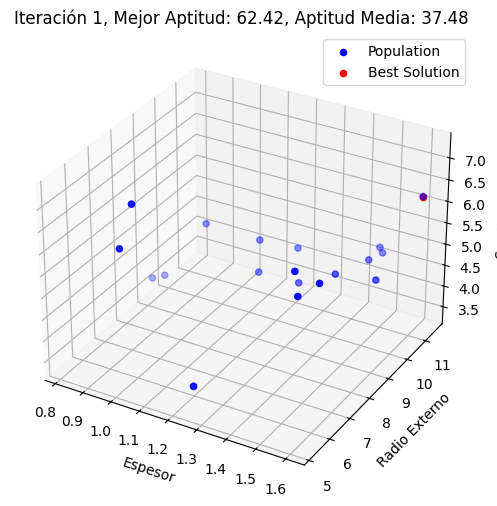

Iteración 1, Mejor Solución: [ 1.60459526 11.48742294  6.19096936], Mejor Aptitud: 62.42373422320517
CG iteration 1, residual = 792746.7550817679     
CG iteration 2, residual = 4.722066169648146e-10     
Máximo valor de la temperatura: 287.56682843673514
CG iteration 1, residual = 782322.3527342407     
CG iteration 2, residual = 5.105920806795006e-10     
Máximo valor de la temperatura: 287.72803859599793
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 782322.3527342407     
CG iteration 2, residual = 5.105920806795006e-10     
Máximo valor de la temperatura: 287.72803859599793
CG iteration 1, residual = 740819.95591352     
CG iteration 2, residual = 4.391517100748252e-10     
Máximo valor de la temperatura: 288.2840675470551
CG iteration 1, residual = 782322.3527342407     
CG iteration 2, residual = 5.105920806795006e-10     
Máximo valor de la tempe

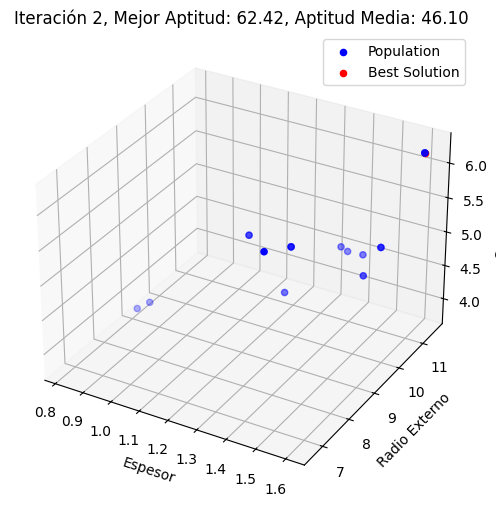

Iteración 2, Mejor Solución: [ 1.60459526 11.48742294  6.19096936], Mejor Aptitud: 62.42373422320517
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 720804.7071423713     
CG iteration 2, residual = 4.5794626982717647e-10     
Máximo valor de la temperatura: 288.55188177441937
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 740819.95591352     
CG iteration 2, residual = 4.391517100748252e-10     
Máximo valor de la temperatura: 288.2840675470551
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temper

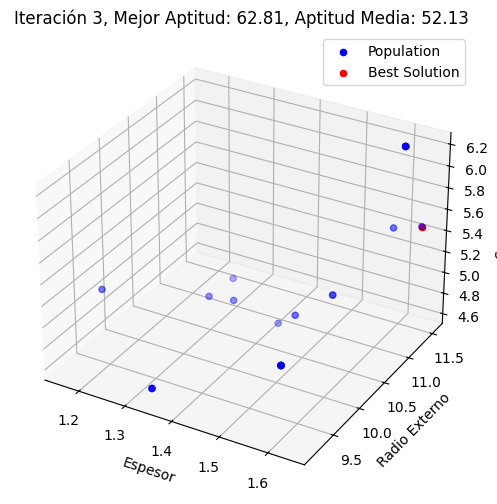

Iteración 3, Mejor Solución: [ 1.63887491 11.5415194   5.469303  ], Mejor Aptitud: 62.80982864044858
CG iteration 1, residual = 725872.5395797944     
CG iteration 2, residual = 4.611469854907608e-10     
Máximo valor de la temperatura: 288.5180889955013
CG iteration 1, residual = 667265.7709698417     
CG iteration 2, residual = 3.973901566401933e-10     
Máximo valor de la temperatura: 289.4793396188326
CG iteration 1, residual = 747627.705809931     
CG iteration 2, residual = 4.63089183371876e-10     
Máximo valor de la temperatura: 288.1775084240946
CG iteration 1, residual = 751327.0482570365     
CG iteration 2, residual = 4.683276216851512e-10     
Máximo valor de la temperatura: 288.1453719780206
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperat

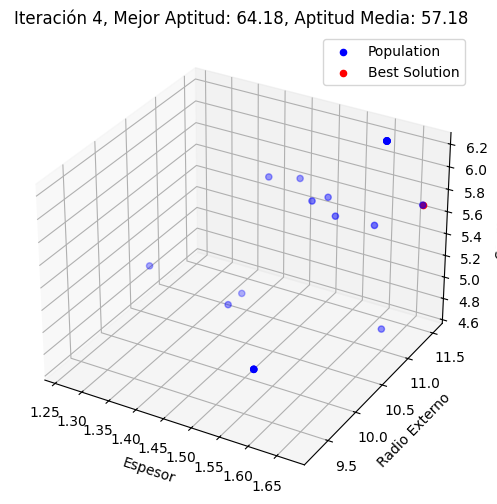

Iteración 4, Mejor Solución: [ 1.66778487 11.52818864  5.68903511], Mejor Aptitud: 64.17535438891112
CG iteration 1, residual = 755109.5771625229     
CG iteration 2, residual = 4.588525617811643e-10     
Máximo valor de la temperatura: 288.0932319355246
CG iteration 1, residual = 751516.136865394     
CG iteration 2, residual = 5.551093350707997e-10     
Máximo valor de la temperatura: 288.155236538448
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 739031.9753120046     
CG iteration 2, residual = 5.266016521326027e-10     
Máximo valor de la temperatura: 288.34345352818565
CG iteration 1, residual = 723455.0696824865     
CG iteration 2, residual = 4.667183088378065e-10     
Máximo valor de la temperatura: 288.6038890863967
CG iteration 1, residual = 730380.5861005406     
CG iteration 2, residual = 4.850812542995402e-10     
Máximo valor de la tempera

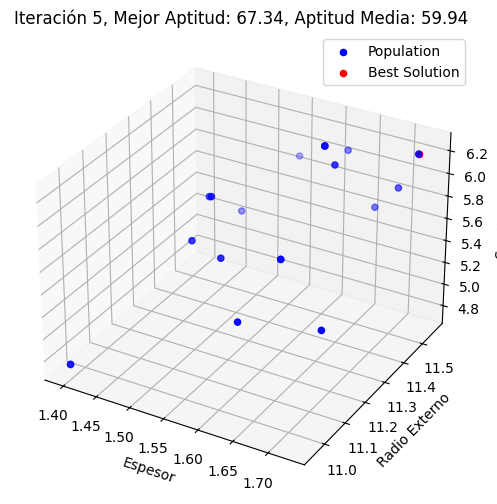

Iteración 5, Mejor Solución: [ 1.72660735 11.53155265  6.24842507], Mejor Aptitud: 67.33710341427575
CG iteration 1, residual = 704563.5275778952     
CG iteration 2, residual = 4.2834106676714676e-10     
Máximo valor de la temperatura: 288.9019064041105
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 750063.7287419378     
CG iteration 2, residual = 4.6550331065600903e-10     
Máximo valor de la temperatura: 288.15021498310495
CG iteration 1, residual = 747480.873574527     
CG iteration 2, residual = 4.967018491720479e-10     
Máximo valor de la temperatura: 288.2056447397061
CG iteration 1, residual = 700517.0547707526     
CG iteration 2, residual = 4.4167975902424584e-10     
Máximo valor de la temperatura: 289.00847051559
CG iteration 1, residual = 725975.4666533875     
CG iteration 2, residual = 4.5305195883032375e-10     
Máximo valor de la temp

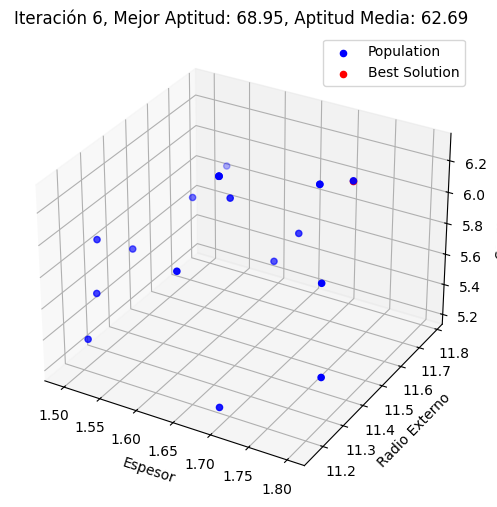

Iteración 6, Mejor Solución: [ 1.7640792  11.55469177  6.29268762], Mejor Aptitud: 68.95182723270278
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 713326.3627198834     
CG iteration 2, residual = 4.776115143428544e-10     
Máximo valor de la temperatura: 288.7243443954549
CG iteration 1, residual = 723455.0696824865     
CG iteration 2, residual = 4.667183088378065e-10     
Máximo valor de la temperatura: 288.6038890863967
CG iteration 1, residual = 687744.6991184679     
CG iteration 2, residual = 4.168295995425819e-10     
Máximo valor de la temperatura: 289.1938252662845
CG iteration 1, residual = 710779.7934007166     
CG iteration 2, residual = 4.5961097741709845e-10     
Máximo valor de la tempe

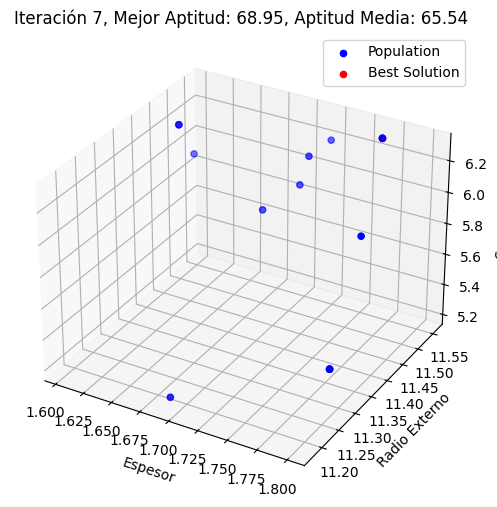

Iteración 7, Mejor Solución: [ 1.7640792  11.55469177  6.29268762], Mejor Aptitud: 68.95182723270278
CG iteration 1, residual = 710779.7934007166     
CG iteration 2, residual = 4.5961097741709845e-10     
Máximo valor de la temperatura: 288.83246083569156
CG iteration 1, residual = 738851.1956014053     
CG iteration 2, residual = 4.813720942862222e-10     
Máximo valor de la temperatura: 288.3628670752245
CG iteration 1, residual = 713145.8446372699     
CG iteration 2, residual = 4.818655396117378e-10     
Máximo valor de la temperatura: 288.75001045104426
CG iteration 1, residual = 718633.5545131059     
CG iteration 2, residual = 4.793004249100441e-10     
Máximo valor de la temperatura: 288.6905134635538
CG iteration 1, residual = 692911.8951896885     
CG iteration 2, residual = 4.396848578031444e-10     
Máximo valor de la temperatura: 289.11558083923995
CG iteration 1, residual = 695511.1447710989     
CG iteration 2, residual = 4.2581035886002823e-10     
Máximo valor de la t

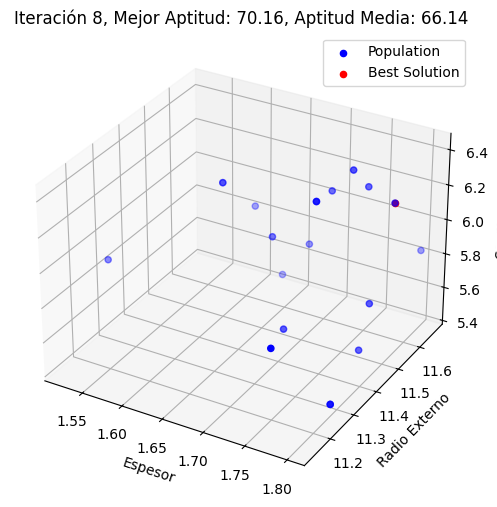

Iteración 8, Mejor Solución: [ 1.8        11.53757429  6.26612581], Mejor Aptitud: 70.15508266196754
CG iteration 1, residual = 701953.9639290584     
CG iteration 2, residual = 4.6497187751909473e-10     
Máximo valor de la temperatura: 288.9741604539349
CG iteration 1, residual = 720818.64917274     
CG iteration 2, residual = 4.4393348527263547e-10     
Máximo valor de la temperatura: 288.63543436907685
CG iteration 1, residual = 687744.6991184679     
CG iteration 2, residual = 4.168295995425819e-10     
Máximo valor de la temperatura: 289.1938252662845
CG iteration 1, residual = 695511.1447710989     
CG iteration 2, residual = 4.2581035886002823e-10     
Máximo valor de la temperatura: 289.07041818868936
CG iteration 1, residual = 703163.9615259706     
CG iteration 2, residual = 4.313422576743145e-10     
Máximo valor de la temperatura: 288.97312931150833
CG iteration 1, residual = 713326.3627198834     
CG iteration 2, residual = 4.776115143428544e-10     
Máximo valor de la te

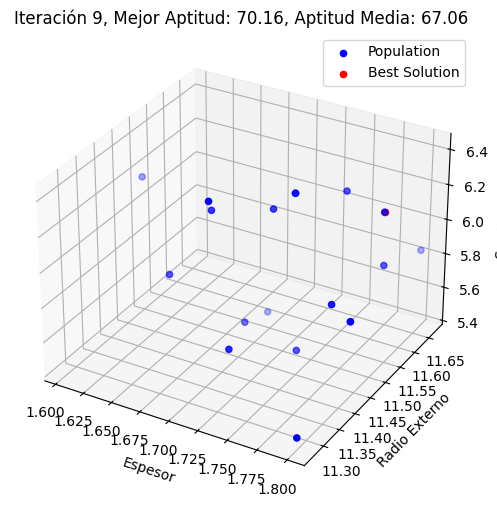

Iteración 9, Mejor Solución: [ 1.8        11.53757429  6.26612581], Mejor Aptitud: 70.15508266196754
CG iteration 1, residual = 700180.1675632625     
CG iteration 2, residual = 4.630029517227628e-10     
Máximo valor de la temperatura: 289.01823514229915
CG iteration 1, residual = 707950.617876207     
CG iteration 2, residual = 4.6180859368467604e-10     
Máximo valor de la temperatura: 288.8074920649392
CG iteration 1, residual = 709628.7467625722     
CG iteration 2, residual = 4.796192952685986e-10     
Máximo valor de la temperatura: 288.79251971797066
CG iteration 1, residual = 699492.9150767635     
CG iteration 2, residual = 5.045354704157685e-10     
Máximo valor de la temperatura: 288.9952910870685
CG iteration 1, residual = 715041.1768529904     
CG iteration 2, residual = 4.487391974225496e-10     
Máximo valor de la temperatura: 288.7043623377617
CG iteration 1, residual = 698747.8915985697     
CG iteration 2, residual = 4.5850765573119897e-10     
Máximo valor de la tem

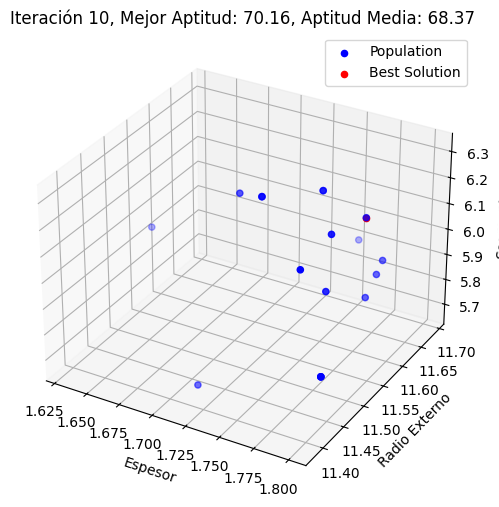

Iteración 10, Mejor Solución: [ 1.8        11.53757429  6.26612581], Mejor Aptitud: 70.15508266196754
Mejor Solución Final (espesor, radio_externo, segmentos): [ 1.8        11.53757429  6.26612581]
Mejor Aptitud Final: 70.15508266196754


In [4]:
# Algoritmo genético
for j in range(num_iterations):
    # Selección de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualización de la población
    population = np.array(new_population)

    # Evaluación de la población
    fitness = np.array([objective_function(x, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualización de la mejor solución
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]

    # Visualización
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(population[:, 0], population[:, 1], population[:, 2], c='b', label='Population')
    ax.scatter(best_solution[0], best_solution[1], best_solution[2], c='r', label='Best Solution')
    ax.set_xlabel('Espesor')
    ax.set_ylabel('Radio Externo')
    ax.set_zlabel('Segmento')
    ax.set_title(f"Iteración {j+1}, Mejor Aptitud: {best_fitness:.2f}, Aptitud Media: {mean_fitness:.2f}")
    ax.legend()
    plt.show()

    print(f"Iteración {j+1}, Mejor Solución: {best_solution}, Mejor Aptitud: {best_fitness}")

# Mostrar resultados finales
print(f"Mejor Solución Final (espesor, radio_externo, segmentos): {best_solution}")
print(f"Mejor Aptitud Final: {best_fitness}")

In [6]:
# Calcular y mostrar la mejor solución con su geometría y resultados
area, temp_max = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], segmentos=best_solution[2], graficar=True)
print(f"Mejor Solución (espesor, radio_externo): {best_solution}")
print(f"Área: {area}, Temperatura Máxima: {temp_max}")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  141.753

CG iteration 1, residual = 700314.0223406866     
CG iteration 2, residual = 4.24148374178402e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.9726676054541
Mejor Solución (espesor, radio_externo): [ 1.8        11.53757429  6.26612581]
Área:  141.753
, Temperatura Máxima: 288.9726676054541


- Se añade una lista `mean_fitnesses` para almacenar la media de la aptitud en cada iteración.
- En cada iteración del algoritmo genético, se calcula y se añade la media de la aptitud a la lista.
- Al finalizar las iteraciones, se grafica la media de la aptitud en función de las iteraciones.
- Se muestra la mejor solución final encontrada, junto con su área y temperatura máxima, así como la mejor aptitud final.


CG iteration 1, residual = 701952.6234586862     
CG iteration 2, residual = 4.293701638979598e-10     
Máximo valor de la temperatura: 288.95133773555057
CG iteration 1, residual = 708983.4498468225     
CG iteration 2, residual = 4.2788146381036413e-10     
Máximo valor de la temperatura: 288.835847960924
CG iteration 1, residual = 698747.8915985697     
CG iteration 2, residual = 4.5850765573119897e-10     
Máximo valor de la temperatura: 289.02176458245555
CG iteration 1, residual = 710779.7934007166     
CG iteration 2, residual = 4.5961097741709845e-10     
Máximo valor de la temperatura: 288.83246083569156
CG iteration 1, residual = 695511.1447710989     
CG iteration 2, residual = 4.2581035886002823e-10     
Máximo valor de la temperatura: 289.07041818868936
CG iteration 1, residual = 712550.9619275911     
CG iteration 2, residual = 4.457050385800674e-10     
Máximo valor de la temperatura: 288.79145794612117
CG iteration 1, residual = 702332.8283170892     
CG iteration 2, re

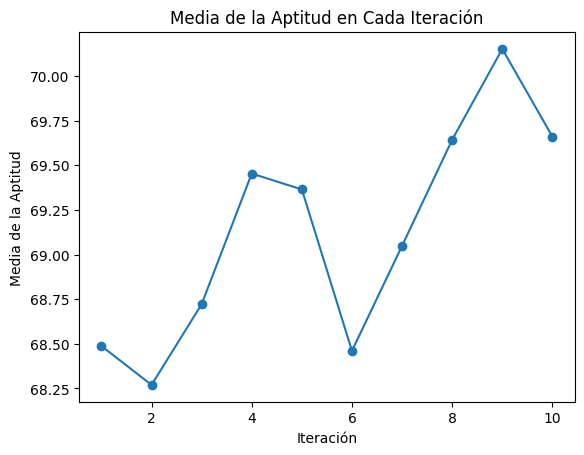

Mejor Solución Final (espesor, radio_externo, segmentos): [ 1.8        11.79194722  6.13960489]


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Área de la geometría:  144.186

CG iteration 1, residual = 707965.6500414067     
CG iteration 2, residual = 4.520604666988815e-10     


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Máximo valor de la temperatura: 288.8708418586738
Área de la mejor solución:  144.186
, Temperatura Máxima: 288.8708418586738, Mejor Aptitud Final: 71.37190332214686


In [7]:
mean_fitnesses = []  # Lista para almacenar la media de la aptitud en cada iteración

# Algoritmo genético
for j in range(num_iterations):
    # Selección de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualización de la población
    population = np.array(new_population)

    # Evaluación de la población
    fitness = np.array([objective_function(x, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualización de la mejor solución
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]

# Graficar la media de la aptitud en cada iteración
plt.figure()
plt.plot(range(1, num_iterations + 1), mean_fitnesses, marker='o')
plt.xlabel('Iteración')
plt.ylabel('Media de la Aptitud')
plt.title('Media de la Aptitud en Cada Iteración')
plt.show()

# Mostrar resultados finales
print(f"Mejor Solución Final (espesor, radio_externo, segmentos): {best_solution}")
area, temp_max = areamax_tempmax(espesor=best_solution[0], radio_externo=best_solution[1], segmentos=best_solution[2], graficar=True)
print(f"Área de la mejor solución: {area}, Temperatura Máxima: {temp_max}, Mejor Aptitud Final: {best_fitness}")

- Se añaden listas `best_solutions` y `mean_fitnesses` para almacenar la mejor solución y el fitness medio por iteración, respectivamente.
- En cada iteración del algoritmo genético, se guarda la mejor solución encontrada y se añade su fitness medio a las listas.
- Al finalizar las iteraciones, se grafica la mejora de las soluciones en función de las iteraciones para cada variable de diseño, así como la distribución de soluciones en la primera y última generación.
- Se muestra también el valor del fitness medio en función de las iteracions.


CG iteration 1, residual = 701450.3783376351     
CG iteration 2, residual = 4.282726253250328e-10     
Máximo valor de la temperatura: 288.96240067396457
CG iteration 1, residual = 721049.7797953464     
CG iteration 2, residual = 4.827249639776382e-10     
Máximo valor de la temperatura: 288.64198455041713
CG iteration 1, residual = 709846.6313758417     
CG iteration 2, residual = 4.898296129494389e-10     
Máximo valor de la temperatura: 288.85093251518333
CG iteration 1, residual = 710217.5862554784     
CG iteration 2, residual = 4.162141600339258e-10     
Máximo valor de la temperatura: 288.82746190406135
CG iteration 1, residual = 708073.3549578107     
CG iteration 2, residual = 4.5699965601586784e-10     
Máximo valor de la temperatura: 288.87073518695183
CG iteration 1, residual = 724505.1794417102     
CG iteration 2, residual = 4.359868909240468e-10     
Máximo valor de la temperatura: 288.58209081733463
CG iteration 1, residual = 700721.5788747434     
CG iteration 2, res

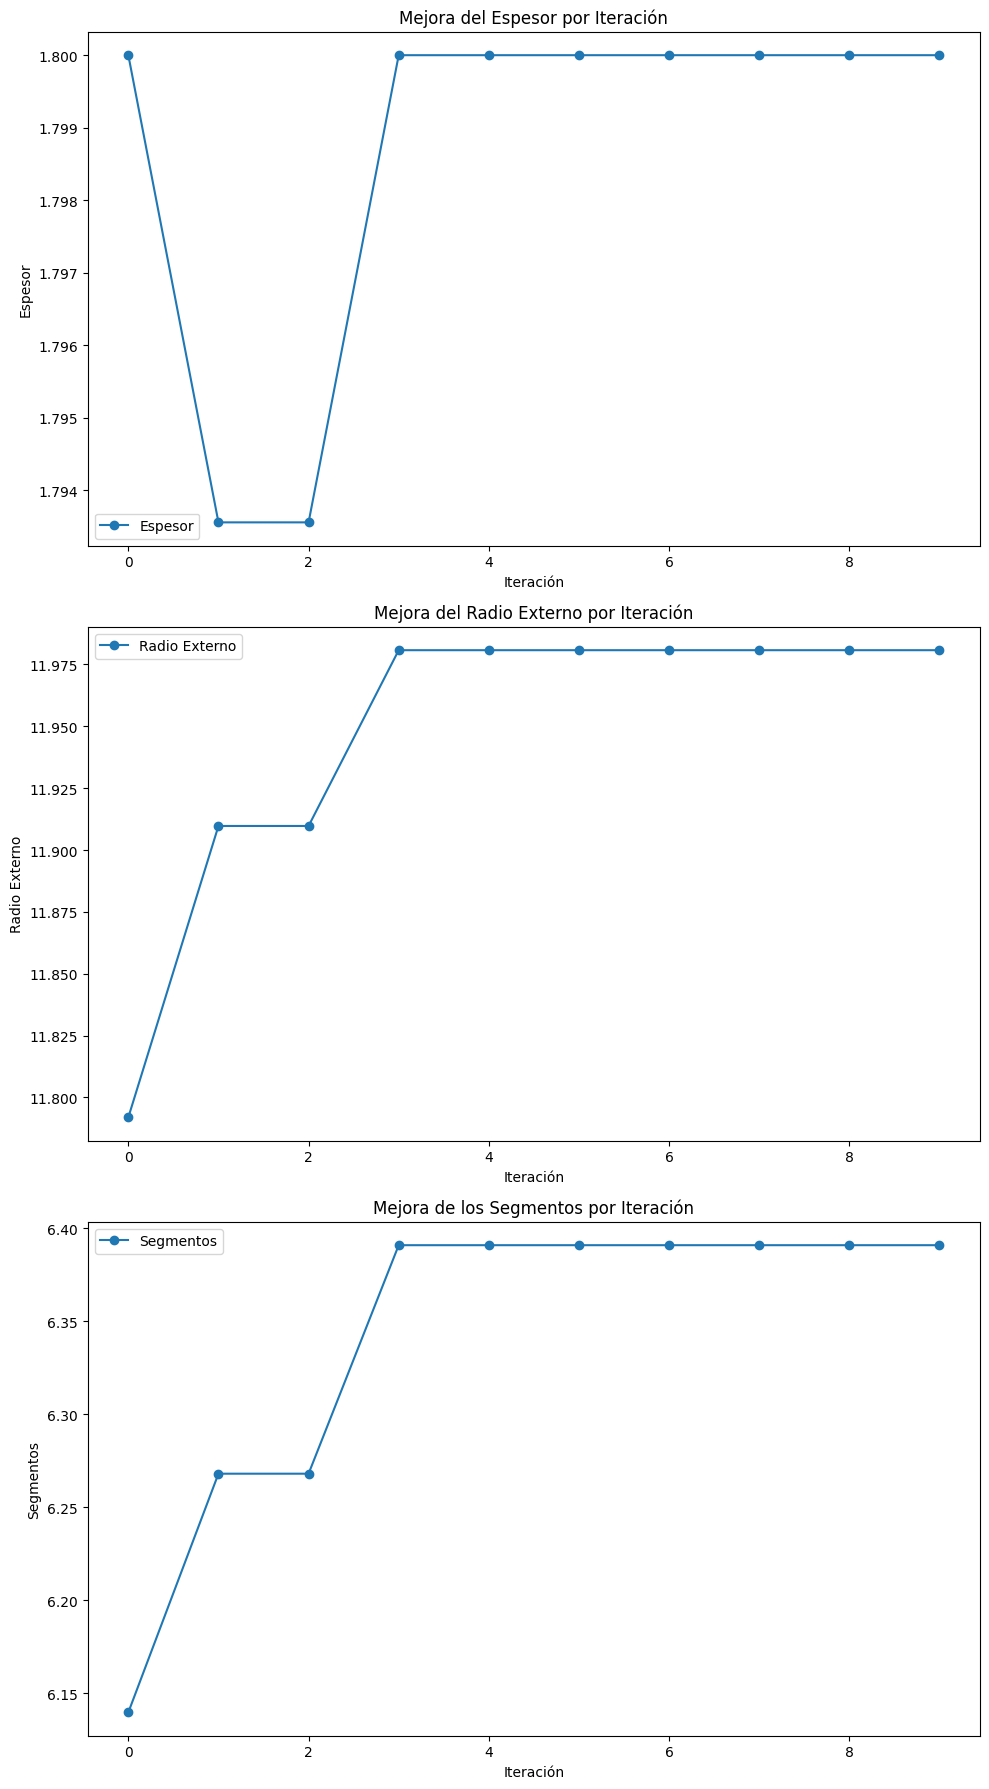

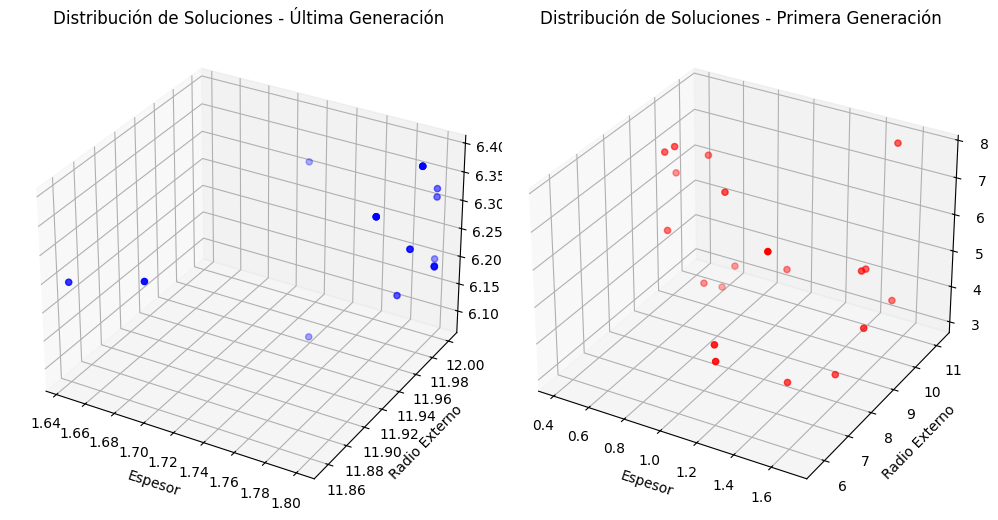

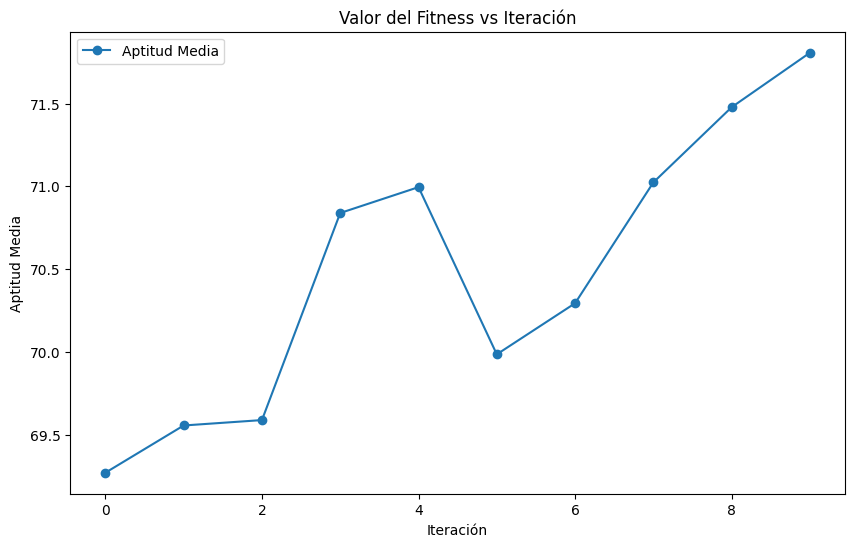

In [8]:
# Inicializa para guardar la mejor solución y el fitness medio por iteración
best_solutions = []
mean_fitnesses = []

# Algoritmo genético
for j in range(num_iterations):
    # Selección de padres y cruce
    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parents(population, fitness)
        parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])

    # Elitismo
    if elitism:
        num_elite = int(population_size * 0.10)
        elite_idxs = np.argsort(fitness)[-
    num_elite:]
        new_population[:num_elite] = population[elite_idxs]

    # Actualización de la población
    population = np.array(new_population)

    # Evaluación de la población
    fitness = np.array([objective_function(x, graficar=False) for x in population])
    mean_fitness = np.mean(fitness)
    mean_fitnesses.append(mean_fitness)

    # Actualización de la mejor solución
    if np.max(fitness) >= best_fitness:
        best_fitness = np.max(fitness)
        best_solution = population[np.argmax(fitness)]

    # Guardar las mejores soluciones
    best_solutions.append(best_solution)

    # Visualización de la mejora de las soluciones
    print(f"Iteración {j+1}, Mejor Solución: {best_solution}, Mejor Aptitud: {best_fitness}")

# Graficar la mejora de las soluciones (resaltar las variables de diseño y función fitness)
best_solutions = np.array(best_solutions)
fig, ax = plt.subplots(3, 1, figsize=(10, 18))

ax[0].plot(range(num_iterations), best_solutions[:, 0], 'o-', label='Espesor')
ax[0].set_xlabel('Iteración')
ax[0].set_ylabel('Espesor')
ax[0].set_title('Mejora del Espesor por Iteración')
ax[0].legend()

ax[1].plot(range(num_iterations), best_solutions[:, 1], 'o-', label='Radio Externo')
ax[1].set_xlabel('Iteración')
ax[1].set_ylabel('Radio Externo')
ax[1].set_title('Mejora del Radio Externo por Iteración')
ax[1].legend()

ax[2].plot(range(num_iterations), best_solutions[:, 2], 'o-', label='Segmentos')
ax[2].set_xlabel('Iteración')
ax[2].set_ylabel('Segmentos')
ax[2].set_title('Mejora de los Segmentos por Iteración')
ax[2].legend()

plt.tight_layout()
plt.show()

# Distribución de soluciones en la primera y última generación
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(population[:, 0], population[:, 1], population[:, 2], c='b', label='Última Generación')
ax1.set_xlabel('Espesor')
ax1.set_ylabel('Radio Externo')
ax1.set_zlabel('Segmentos')
ax1.set_title('Distribución de Soluciones - Última Generación')

ax2 = fig.add_subplot(122, projection='3d')
initial_population = np.random.rand(population_size, 3)
initial_population[:, 0] = initial_population[:, 0] * (espesor_range[1] - espesor_range[0]) + espesor_range[0]
initial_population[:, 1] = initial_population[:, 1] * (radio_externo_range[1] - radio_externo_range[0]) + radio_externo_range[0]
initial_population[:, 2] = initial_population[:, 2] * (segmentos_range[1] - segmentos_range[0]) + segmentos_range[0]
ax2.scatter(initial_population[:, 0], initial_population[:, 1], initial_population[:, 2], c='r', label='Primera Generación')
ax2.set_xlabel('Espesor')
ax2.set_ylabel('Radio Externo')
ax2.set_zlabel('Segmentos')
ax2.set_title('Distribución de Soluciones - Primera Generación')

plt.tight_layout()
plt.show()

# Graficar el valor del fitness vs iteración
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), mean_fitnesses, 'o-', label='Aptitud Media')
plt.xlabel('Iteración')
plt.ylabel('Aptitud Media')
plt.title('Valor del Fitness vs Iteración')
plt.legend()
plt.show()

Para posibles provle